In [1]:
# read csv file and print out the data
import csv
import sys
import os
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

from helper import transform_polars_df

In [2]:
datapath = '../data/2011-2012 Solar home electricity data v2.csv'
# skip the first line in csv and read the next line as column
# then read the rest of the file and store as dataframe
df = pl.read_csv(datapath, skip_rows=1)
print(df)
print(df.columns)

shape: (270_304, 54)
┌──────────┬───────────┬──────────┬──────────────────────┬───┬───────┬───────┬───────┬─────────────┐
│ Customer ┆ Generator ┆ Postcode ┆ Consumption Category ┆ … ┆ 23:00 ┆ 23:30 ┆ 0:00  ┆ Row Quality │
│ ---      ┆ Capacity  ┆ ---      ┆ ---                  ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---         │
│ i64      ┆ ---       ┆ i64      ┆ str                  ┆   ┆ f64   ┆ f64   ┆ f64   ┆ str         │
│          ┆ f64       ┆          ┆                      ┆   ┆       ┆       ┆       ┆             │
╞══════════╪═══════════╪══════════╪══════════════════════╪═══╪═══════╪═══════╪═══════╪═════════════╡
│ 1        ┆ 3.78      ┆ 2076     ┆ CL                   ┆ … ┆ 0.0   ┆ 0.0   ┆ 1.063 ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ GC                   ┆ … ┆ 0.118 ┆ 0.219 ┆ 0.162 ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ GG                   ┆ … ┆ 0.0   ┆ 0.0   ┆ 0.0   ┆ null        │
│ 1        ┆ 3.78      ┆ 2076     ┆ CL                   ┆ … ┆ 0.0   ┆

In [3]:
# get all the unique customers as their own dataframes
customers = df['Customer'].unique()
# pick 80% of the random customers as training data
training_customers = np.random.choice(customers, int(0.8*len(customers)), replace=False)
# the rest of the customers are testing data
testing_customers = np.setdiff1d(customers, training_customers)

In [4]:
# save the customers number to a csv file
np.savetxt('../data/training_customers.csv', training_customers, fmt='%s')
np.savetxt('../data/testing_customers.csv', testing_customers, fmt='%s')

In [4]:
# alternatively, we can get the training and testing customers from the csv file
training_customers = np.loadtxt('../data/training_customers.csv', dtype=int)
testing_customers = np.loadtxt('../data/testing_customers.csv', dtype=int)

In [5]:
# loop through each customer and use transform_polars_df to get the dataframe and store it in a list call dataset
training_dataset = []
for customer in training_customers:
    customer_df = df.filter(pl.col('Customer') == customer)
    try:
        newcustomerdf = transform_polars_df(customer_df, import_energy_price=0.23, export_energy_price=0.015, price_periods="7am – 10am | 4pm – 9pm", default_import_energy_price=0.15, default_export_energy_price=0.01)
    except Exception as e:
        print(f"Error with customer as training dataset: {customer}")
        print(e)
        break
    training_dataset.append(newcustomerdf)

testing_dataset = []
for customer in testing_customers:
    customer_df = df.filter(pl.col('Customer') == customer)
    try:
        newcustomerdf = transform_polars_df(customer_df, import_energy_price=0.23, export_energy_price=0.015, price_periods="7am – 10am | 4pm – 9pm", default_import_energy_price=0.15, default_export_energy_price=0.01)
    except Exception as e:
        print(f"Error with customer as testing dataset: {customer}")
        print(e)
        break
    testing_dataset.append(newcustomerdf)


In [5]:
testing_dataset[0]

Timestamp,SolarGen,HouseLoad,FutureSolar,FutureLoad,ImportEnergyPrice,ExportEnergyPrice,Time
i64,f64,f64,f64,f64,f64,f64,datetime[μs]
1309478400000000,0.0,0.198,0.006,2.781,0.15,0.01,2011-07-01 00:00:00
1309480200000000,0.006,2.781,0.0,2.688,0.15,0.01,2011-07-01 00:30:00
1309482000000000,0.0,2.688,0.0,2.539,0.15,0.01,2011-07-01 01:00:00
1309483800000000,0.0,2.539,0.0,2.573,0.15,0.01,2011-07-01 01:30:00
1309485600000000,0.0,2.573,0.0,2.501,0.15,0.01,2011-07-01 02:00:00
…,…,…,…,…,…,…,…
1341090000000000,0.0,0.55,0.0,0.225,0.23,0.015,2012-06-30 21:00:00
1341091800000000,0.0,0.225,0.0,0.327,0.15,0.01,2012-06-30 21:30:00
1341093600000000,0.0,0.327,0.0,0.24,0.15,0.01,2012-06-30 22:00:00


In [6]:
import gymnasium as gym

from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_checker import check_env
from EnergySimEnv import SolarBatteryEnv
from helper import make_env

# Create a list of environment creation functions to build a vectorized environment.
training_env_fns = [make_env(ds) for ds in training_dataset]
training_vec_env = DummyVecEnv(training_env_fns)

num_total_steps = len(training_dataset[0])
print(f"Total number of steps possible in training dataset: {num_total_steps}")

testing_env_fns = [make_env(ds) for ds in testing_dataset]


Total number of steps possible in training dataset: 17567


/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [8]:
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from sb3train import train_model

#ppo_model, _ = train_model(model_class=PPO, vec_env=training_vec_env, total_timesteps= num_total_steps, eval_env_fn=testing_env_fns[5], default_model=True)


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Training the model with the best hyperparameters...
training complete.


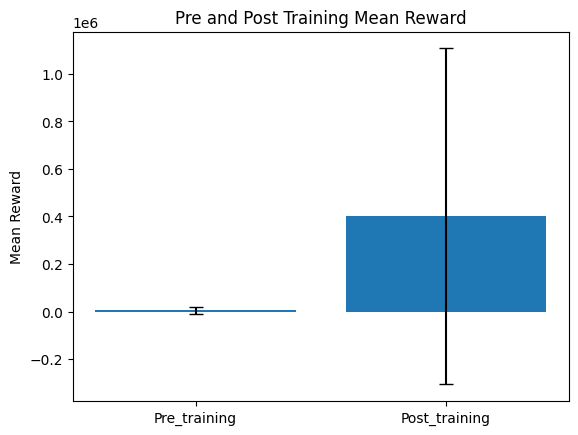

In [9]:
a2c_model, _ = train_model(model_class=A2C, vec_env=training_vec_env, total_timesteps= 3, eval_env_fn=testing_env_fns[4], default_model=True)

In [17]:
print(_)

{'Pre_training': {'mean_reward': np.float64(6502.9615314), 'std_reward': np.float64(17137.519195243138)}, 'Post_training': {'mean_reward': np.float64(226342.4243034), 'std_reward': np.float64(35718.0305312)}}


In [10]:
# create an agent with the trained RL model and record one interaction with the environment
env = testing_env_fns[2]()

from decision import Agent
agent = Agent(env, algorithm='rl', model = a2c_model)

/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [11]:
# examine the agent's interaction with the environment step by step
obs, info = env.reset()

done = False
while not done:
    action = a2c_model.predict(obs, deterministic=True)

    print(f"Action: {action}")
    print(f"Observation: {obs}")
    #obs, reward, done, info = env.step(action)
    #print(f"Action: {action}, Reward: {reward}, Done: {done}")
    #print(f"Observation: {obs}")
    #print(f"Info: {info}")
    break

Action: (array([0.31439137], dtype=float32), None)
Observation: [1.3094784e+15 0.0000000e+00 1.4700000e-01 0.0000000e+00 6.3999999e-01
 1.5000001e-01 9.9999998e-03 5.0000000e+00 0.0000000e+00]


In [13]:
results_df = agent.run_episode()

In [14]:
# check for unique action
print("Unique actions taken by the agent:")
print(results_df['action'].unique())

Unique actions taken by the agent:
shape: (1,)
Series: 'action' [f64]
[
	0.314391
]


In [7]:
evaluation_results = {}

In [8]:
import optuna
import numpy as np
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy

from sb3train import optimize_sb3, a2c_model_kwargs_fn, ddpg_model_kwargs_fn



In [8]:
study_ppo = optuna.create_study(direction="maximize")
study_ppo.optimize(
    lambda trial: optimize_sb3(
        trial,
        model_class=PPO,
        vec_env=vec_env,
        eval_env_fn=testing_env_fns[0],
        model_kwargs_fn=ppo_model_kwargs_fn,
        total_timesteps=40000
    ),
    n_trials=20, n_jobs=12
)
print("Best PPO trial:", study_ppo.best_trial.params)

[I 2025-05-14 14:11:54,473] A new study created in memory with name: no-name-f4c760a2-eca5-4858-b16f-200124b07c63
/tmp/ipykernel_5073/3446703909.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipykernel_5073/3446703909.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
/tmp/ipykernel_5073/3446703909.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  clip_range = trial.suggest_uniform("clip_range", 0.1, 0.3)
/tmp/i

Best PPO trial: {'learning_rate': 4.1960832284015576e-05, 'gamma': 0.9932379877939986, 'clip_range': 0.1501217428295711, 'ent_coef': 4.669120740207693e-07, 'vf_coef': 0.9126270286857858, 'net_arch': 'medium'}


In [ ]:
study_a2c = optuna.create_study(direction="maximize")
study_a2c.optimize(
    lambda trial: optimize_sb3(
        trial,
        model_class=A2C,
        vec_env=vec_env,
        eval_env_fn=testing_env_fns[0],
        model_kwargs_fn=a2c_model_kwargs_fn,
        total_timesteps=40000
    ),
    n_trials=20, n_jobs=12
)
print("Best A2C trial:", study_a2c.best_trial.params)

In [9]:
study_ddpg = optuna.create_study(direction="maximize")
study_ddpg.optimize(
    lambda trial: optimize_sb3(
        trial,
        model_class=DDPG,
        vec_env=vec_env,
        eval_env_fn=testing_env_fns[0],
        model_kwargs_fn=ddpg_model_kwargs_fn,
        total_timesteps=40000
    ),
    n_trials=20
)
print("Best DDPG trial:", study_ddpg.best_trial.params)

[I 2025-05-15 06:29:14,545] A new study created in memory with name: no-name-47c6603e-2121-456d-bd1a-3ea985e7981b
/code/src/sb3train.py:128: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/code/src/sb3train.py:129: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  tau = trial.suggest_uniform("tau", 0.001, 0.02)
/code/src/sb3train.py:130: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
/usr/local/lib/python3.10/dist-packages/gymnasium/

Best DDPG trial: {'learning_rate': 0.00047212976531735425, 'tau': 0.01774915178228668, 'gamma': 0.9429368024006545, 'batch_size': 256, 'net_arch': 'small'}


In [11]:
# Retrieve best parameters from the Optuna study
best_params = study_ppo.best_trial.params

# Determine network architecture based on the best net_arch choice
if best_params["net_arch"] == "small":
    net_arch = [64, 64]
elif best_params["net_arch"] == "medium":
    net_arch = [256, 256]
else:
    net_arch = [400, 300]

policy_kwargs = dict(net_arch=net_arch)

# Instantiate PPO model with best parameters
ppo_model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=best_params["learning_rate"],
    gamma=best_params["gamma"],
    clip_range=best_params["clip_range"],
    ent_coef=best_params["ent_coef"],
    vf_coef=best_params["vf_coef"],
    policy_kwargs=policy_kwargs
)

# Optionally, evaluate before training
mean_reward, std_reward = evaluate_policy(
    ppo_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False
)
evaluation_results['PPO_pre_training'] = {
    'mean_reward': mean_reward,
    'std_reward': std_reward
}

# Train the model using the tuned hyperparameters
ppo_model.learn(total_timesteps=num_total_steps)

# Evaluate after training
mean_reward, std_reward = evaluate_policy(
    ppo_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False
)
evaluation_results['PPO_post_training'] = {
    'mean_reward': mean_reward,
    'std_reward': std_reward
}

# Save the trained model
ppo_model.save("ppo_agent")

Using cuda device
-------------------------------
| time/              |        |
|    fps             | 11753  |
|    iterations      | 1      |
|    time_elapsed    | 41     |
|    total_timesteps | 491520 |
-------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2540         |
|    iterations           | 2            |
|    time_elapsed         | 386          |
|    total_timesteps      | 983040       |
| train/                  |              |
|    approx_kl            | 0.0025952135 |
|    clip_fraction        | 0.0844       |
|    clip_range           | 0.15         |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0            |
|    learning_rate        | 4.2e-05      |
|    loss                 | 1.81e+08     |
|    n_updates            | 10           |
|    policy_gradient_loss | 0.000581     |
|    std                  | 0.989        |
|    value_loss           |

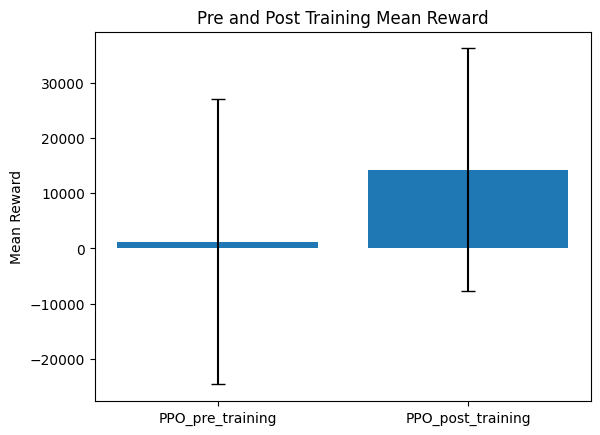

In [13]:
# plot the pre training mean_reward and std_reward against the post training mean_reward and std_reward
x = np.arange(len(evaluation_results))
y = np.array([evaluation_results[key]['mean_reward'] for key in evaluation_results])
yerr = np.array([evaluation_results[key]['std_reward'] for key in evaluation_results])
plt.bar(x, y, yerr=yerr, capsize=5)
plt.xticks(x, list(evaluation_results.keys()))
plt.ylabel('Mean Reward')
plt.title('Pre and Post Training Mean Reward')
plt.show()

In [9]:
import optuna
import numpy as np
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

def optimize_a2c(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
    ent_coef = trial.suggest_loguniform("ent_coef", 1e-8, 1e-2)
    vf_coef = trial.suggest_uniform("vf_coef", 0.1, 1.0)
    
    net_arch_choice = trial.suggest_categorical("net_arch", ["small", "medium", "large"])
    if net_arch_choice == "small":
        net_arch = [64, 64]
    elif net_arch_choice == "medium":
        net_arch = [256, 256]
    else:
        net_arch = [400, 300]
    policy_kwargs = dict(net_arch=net_arch)
    
    model = A2C(
        "MlpPolicy",
        vec_env,
        verbose=0,
        learning_rate=learning_rate,
        gamma=gamma,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        policy_kwargs=policy_kwargs
    )
    
    model.learn(total_timesteps=40000)
    
    mean_reward, _ = evaluate_policy(model, Monitor(testing_env_fns[0]()), n_eval_episodes=3, deterministic=False)
    return mean_reward

study_a2c = optuna.create_study(direction="maximize")
study_a2c.optimize(optimize_a2c, n_trials=20)
print("Best A2C trial:", study_a2c.best_trial.params)

[I 2025-04-01 17:40:37,960] A new study created in memory with name: no-name-2edc2449-6e1b-4426-bb48-7d2d75b725b1
/tmp/ipykernel_4083/3498605266.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipykernel_4083/3498605266.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
/tmp/ipykernel_4083/3498605266.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  ent_coef = trial.suggest_loguniform("ent_coef", 

Best A2C trial: {'learning_rate': 0.00010242690951142487, 'gamma': 0.940782565460527, 'ent_coef': 5.1560837211066594e-06, 'vf_coef': 0.5242206764390721, 'net_arch': 'large'}


In [10]:
# Retrieve best parameters from the A2C Optuna study (assumed to be stored in study_a2c)
best_params_a2c = study_a2c.best_trial.params

# Determine network architecture based on the best net_arch choice
if best_params_a2c["net_arch"] == "small":
    net_arch = [64, 64]
elif best_params_a2c["net_arch"] == "medium":
    net_arch = [256, 256]
else:
    net_arch = [400, 300]

policy_kwargs = dict(net_arch=net_arch)

# Instantiate A2C model with best parameters
a2c_model = A2C(
    "MlpPolicy",
    vec_env,
    verbose=1,
    policy_kwargs=policy_kwargs,
    learning_rate=best_params_a2c["learning_rate"],
    gamma=best_params_a2c["gamma"],
    ent_coef=best_params_a2c["ent_coef"],
    vf_coef=best_params_a2c["vf_coef"],
    device='cpu'
)

# Evaluate before training
mean_reward, std_reward = evaluate_policy(a2c_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['A2C_pre_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}

# Train the A2C model
a2c_model.learn(total_timesteps=num_total_steps)

# Evaluate after training
mean_reward, std_reward = evaluate_policy(a2c_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['A2C_post_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}

# Save the trained model
a2c_model.save("a2c_agent")


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 14154    |
|    iterations         | 100      |
|    time_elapsed       | 8        |
|    total_timesteps    | 120000   |
| train/                |          |
|    entropy_loss       | -1.4     |
|    explained_variance | 0        |
|    learning_rate      | 0.000102 |
|    n_updates          | 99       |
|    policy_loss        | 6.79e+07 |
|    std                | 0.985    |
|    value_loss         | 1.36e+17 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 14302    |
|    iterations         | 200      |
|    time_elapsed       | 16       |
|    total_timesteps    | 240000   |
| train/                |          |
|    entropy_loss       | -1.41    |
|    explained_variance | 0        |
|    learning_rate      | 0.000102 |
|    n_updates          | 199      |
|    policy_loss     

In [11]:
import optuna
import numpy as np
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

n_actions = vec_env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions), 
    sigma=0.2 * np.ones(n_actions)
)

def optimize_ddpg(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    tau = trial.suggest_uniform("tau", 0.001, 0.02)
    gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    # Choose network architecture preset
    net_arch_choice = trial.suggest_categorical("net_arch", ["small", "medium", "large"])
    if net_arch_choice == "small":
        net_arch = [64, 64]
    elif net_arch_choice == "medium":
        net_arch = [256, 256]
    else:
        net_arch = [400, 300]
        
    policy_kwargs = dict(net_arch=net_arch)
    
    # Create DDPG model with sampled hyperparameters.
    model = DDPG(
        "MlpPolicy",
        vec_env,
        verbose=0,
        learning_rate=learning_rate,
        tau=tau,
        gamma=gamma,
        batch_size=batch_size,
        policy_kwargs=policy_kwargs,
        action_noise=action_noise
    )
    
    # Use fewer timesteps for speed; adjust as needed.
    model.learn(total_timesteps=40000)
    
    # Evaluate the policy on a Monitor-wrapped environment.
    mean_reward, _ = evaluate_policy(model, Monitor(testing_env_fns[0]()), n_eval_episodes=3, deterministic=True)
    return mean_reward

study_ddpg = optuna.create_study(direction="maximize")
study_ddpg.optimize(optimize_ddpg, n_trials=20)

print("Best trial:")
trial = study_ddpg.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"  {key}: {value}")

[I 2025-04-01 17:47:31,477] A new study created in memory with name: no-name-50d870aa-3260-4229-8365-63168e872900
/tmp/ipykernel_4083/3177982610.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_4083/3177982610.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  tau = trial.suggest_uniform("tau", 0.001, 0.02)
/tmp/ipykernel_4083/3177982610.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
[I 2025-04-01 17:

Best trial:
Value:  57907392.69658933
Params: 
  learning_rate: 0.00022112152085549454
  tau: 0.0010025593302385523
  gamma: 0.9785903790379802
  batch_size: 64
  net_arch: large


In [20]:
# Retrieve best parameters from the study
best_trial = study_ddpg.best_trial

learning_rate = best_trial.params["learning_rate"]
tau = best_trial.params["tau"]
gamma = best_trial.params["gamma"]
batch_size = best_trial.params["batch_size"]
net_arch_choice = best_trial.params["net_arch"]

if net_arch_choice == "small":
    net_arch = [64, 64]
elif net_arch_choice == "medium":
    net_arch = [256, 256]
else:
    net_arch = [400, 300]

policy_kwargs = dict(net_arch=net_arch)

# Initialize action noise
n_actions = vec_env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions), 
    sigma=0.2 * np.ones(n_actions)  # Adjust sigma to tune exploration
)

# Instantiate DDPG model with the best hyperparameters
ddpg_model = DDPG(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=learning_rate,
    tau=tau,
    gamma=gamma,
    batch_size=batch_size,
    policy_kwargs=policy_kwargs,
    action_noise=action_noise
)
# Train third agent with DDPG

mean_reward, std_reward = evaluate_policy(ddpg_model, Monitor(testing_env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['DDPG_pre_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}
ddpg_model.learn(total_timesteps=num_total_steps)
mean_reward, std_reward = evaluate_policy(ddpg_model, Monitor(env_fns[0]()), n_eval_episodes=5, deterministic=False)
evaluation_results['DDPG_post_training'] = {'mean_reward': mean_reward, 'std_reward': std_reward}
ddpg_model.save("ddpg_agent")

Using cuda device
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 11330     |
|    time_elapsed    | 1         |
|    total_timesteps | 17760     |
| train/             |           |
|    actor_loss      | -1.05e+13 |
|    critic_loss     | 6.44e+23  |
|    learning_rate   | 0.00038   |
|    n_updates       | 73        |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 11490     |
|    time_elapsed    | 3         |
|    total_timesteps | 35520     |
| train/             |           |
|    actor_loss      | -1.05e+13 |
|    critic_loss     | 6.44e+23  |
|    learning_rate   | 0.00038   |
|    n_updates       | 147       |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 12        |
|    fps             | 11491     |
| 

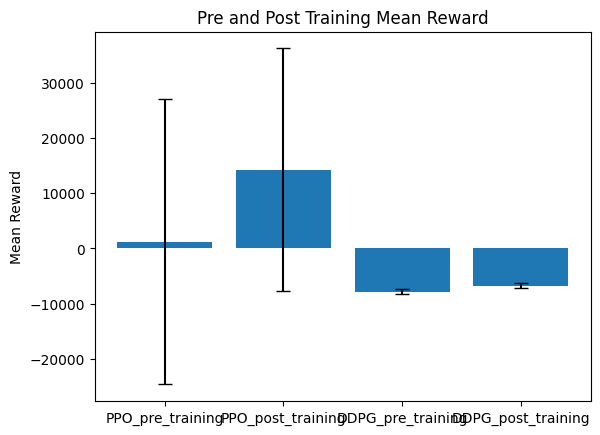

In [21]:
# plot the pre training mean_reward and std_reward against the post training mean_reward and std_reward
x = np.arange(len(evaluation_results))
y = np.array([evaluation_results[key]['mean_reward'] for key in evaluation_results])
yerr = np.array([evaluation_results[key]['std_reward'] for key in evaluation_results])
plt.bar(x, y, yerr=yerr, capsize=5)
plt.xticks(x, list(evaluation_results.keys()))
plt.ylabel('Mean Reward')
plt.title('Pre and Post Training Mean Reward')
plt.show()

In [11]:
# new implementation of Agent with new SDP algorithm
from decision import Agent

"""
SDPagent = Agent(
    env,
    algorithm='sdp',
    degradation_model='static',
    static_deg_correction_factor=0.01
)
"""

"""
SDPagent = Agent(
    env,
    algorithm='sdp',
    soc_resolution=resolution,
    action_resolution=2*resolution+1,
    degradation_model='linear',
    linear_deg_cost_p_kwh=0.2 # based on 5000 cycles life and capcacity of 13.5kWh and replacement cost of $15,300
)
"""
log_list = []
resolution = 20
for i in range(20):
    print(f"Testing customer {i}")
    env = testing_env_fns[i]()
    # check if the environment is valid
    check_env(env, warn=True)
    # check if the environment is valid with monitor and reset
    env.reset()


    agent = Agent(env, algorithm='rule')
    ep_log = agent.run_episode(render=False)
    log_list.append(ep_log)

Testing customer 0
Testing customer 1
Testing customer 2
Testing customer 3
Testing customer 4
Testing customer 5
Testing customer 6
Testing customer 7
Testing customer 8
Testing customer 9
Testing customer 10
Testing customer 11
Testing customer 12
Testing customer 13
Testing customer 14
Testing customer 15
Testing customer 16
Testing customer 17
Testing customer 18
Testing customer 19


In [8]:
# check for unique value in action
unique_actions = np.unique(ep_log['action'])
print(unique_actions)

[array([-0.5]) array([-0.1]) array([-0.05]) array([0.]) array([0.15])]


In [6]:
from decision import run_episodes_parallel, Agent
rule_agent_kwargs = {'algorithm': 'rule'}
# combine testing dataset and training dataset
combined_env_fns = env_fns + testing_env_fns
combined_envs = [env_fn() for env_fn in combined_env_fns]
combined_envs = combined_envs[:20]
rule_episode_logs = run_episodes_parallel(Agent, combined_envs, agent_kwargs=rule_agent_kwargs, max_workers=20)

Episodes:   0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
sdp_agent_kwargs = {
    'algorithm': 'sdp',
    'soc_resolution': 20,
    'action_resolution': 41,
    'degradation_model': 'linear',
    'linear_deg_cost_p_kwh': 0.2
}

# Run all episodes in parallel
sdp_linear_episode_logs = run_episodes_parallel(Agent, combined_envs, agent_kwargs=sdp_agent_kwargs, max_workers=20)

Episodes:   0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
from stable_baselines3 import PPO, A2C, DDPG

ppo_model = PPO.load("ppo_agent")
a2c_model = A2C.load("a2c_agent")
ddpg_model = DDPG.load("ddpg_agent")

In [8]:
all_episodes_logs = []
for i in range(len(testing_dataset)):
    env = testing_env_fns[i]()
    rule_agent = Agent(env, algorithm='rule')
    rule_episode_log = rule_agent.run_episode()
    all_episodes_logs.append(rule_episode_log)
    break

In [15]:
# run all the episodes with all the avaliable rl agents
all_episodes_logs = []
for i in range(len(testing_dataset)):
    env = testing_env_fns[i]()
    ppo_agent = Agent(env, algorithm='rl', model=ppo_model)
    a2c_agent = Agent(env, algorithm='rl', model=a2c_model)
    ddpg_agent = Agent(env, algorithm='rl', model=ddpg_model)
    rule_agent = Agent(env, algorithm='rule')
    ppo_episode_logs = ppo_agent.run_episode()
    a2c_episode_logs = a2c_agent.run_episode()
    ddpg_episode_logs = ddpg_agent.run_episode()
    rule_episode_logs = rule_agent.run_episode()
    all_episodes_logs.append({
        'ppo': ppo_episode_logs,
        'a2c': a2c_episode_logs,
        'ddpg': ddpg_episode_logs,
        'rule': rule_episode_logs
    })

In [9]:
all_episodes_logs

[shape: (7_791, 4)
 ┌─────────────────────────────────┬─────────────┬────────────┬─────────────────────────────────┐
 │ observation                     ┆ action      ┆ reward     ┆ info                            │
 │ ---                             ┆ ---         ┆ ---        ┆ ---                             │
 │ list[f64]                       ┆ list[f64]   ┆ f64        ┆ struct[1]                       │
 ╞═════════════════════════════════╪═════════════╪════════════╪═════════════════════════════════╡
 │ [1.3095e15, 0.0, … 0.0]         ┆ [-0.038826] ┆ -89.487656 ┆ {{0.0,0.097065,4.902936,0.198,… │
 │ [1.3095e15, 0.006, … 89.479584… ┆ [-0.543524] ┆ -15.989127 ┆ {{0.0,1.358809,3.544127,2.781,… │
 │ [1.3095e15, 0.0, … 15.875832]   ┆ [-0.540004] ┆ -16.365965 ┆ {{0.0,1.350009,2.194118,2.688,… │
 │ [1.3095e15, 0.0, … 16.258926]   ┆ [-0.51963]  ┆ -17.403069 ┆ {{0.0,1.299076,0.895041,2.539,… │
 │ [1.3095e15, 0.0, … 17.303875]   ┆ [0.489575]  ┆ -20.871804 ┆ {{1.223938,0.0,2.11898,3.79693… │
 

In [11]:
info_observation = all_episodes_logs[0]['info']
print(len(info_observation))

7791


In [33]:
info_observation[100]

{'reward_info': {'battery_charge': 0.0,
  'battery_discharge': 0.1321033388376236,
  'battery_level': 5.423399994940372,
  'demand': 0.214,
  'supply': 0.1321033388376236,
  'grid_energy': 0.08189666271209717,
  'energy_price': 0.08,
  'grid_violation_penalty': 0,
  'grid_reward': -0.006551732774823904,
  'battery_deg_penalty': 0.005109237577037136,
  'dynamic_deg': 0.004504782348819484,
  'static_deg': 0.005109237577037136,
  'num_cycles': 2,
  'correction_factor': 0.006738952637881747,
  'final_reward': -78.177886661443}}

In [16]:
info_observation = all_episodes_logs[0]['rule']['info']
print(len(info_observation))

test_observation = all_episodes_logs[0]['rule']['observation']
print(len(test_observation))

17566
17566


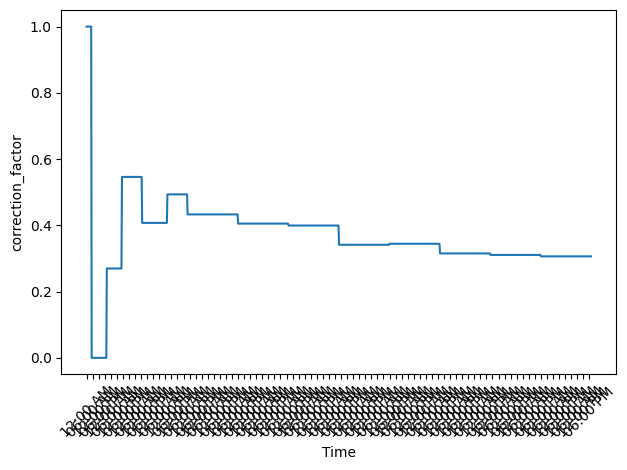

In [12]:
import matplotlib.pyplot as plt

# Convert the Polars series to a list of dictionaries.
slice_start = 0
slice_end = 1000
data = info_observation.to_list()[slice_start:slice_end]

toplot = 'correction_factor'
# Extract the correction_factor, replacing null values with np.nan
plot_factors = []
for entry in data:
    # Check if the reward_info and correction_factor exist; otherwise, use np.nan.
    if entry.get('reward_info') is not None and entry['reward_info'].get(toplot) is not None:
        plot_factors.append(entry['reward_info'][toplot])
    else:
        plot_factors.append(np.nan)

num_points = len(plot_factors)

time_indices = np.arange(slice_start, slice_end)

time_labels = []
for i in time_indices:
    total_minutes = (i * 30) % 1440  # minutes in a day (24*60 = 1440)
    hour = total_minutes // 60
    minute = total_minutes % 60
    # Convert 24h clock to 12h format with AM/PM
    if hour == 0:
        hour_12 = 12
        meridiem = "AM"
    elif hour < 12:
        hour_12 = hour
        meridiem = "AM"
    elif hour == 12:
        hour_12 = hour
        meridiem = "PM"
    else:
        hour_12 = hour - 12
        meridiem = "PM"
    time_labels.append(f"{hour_12:02d}:{minute:02d} {meridiem}")

# Plot your factors with custom x-axis labels.
plt.plot(time_indices, plot_factors)
plt.xlabel("Time")
plt.ylabel(toplot)

# Show labels at a reasonable interval (e.g., every 12 steps = 6 hours)
step = 12
plt.xticks(time_indices[::step], np.array(time_labels)[::step], rotation=45)
plt.tight_layout()
plt.show()

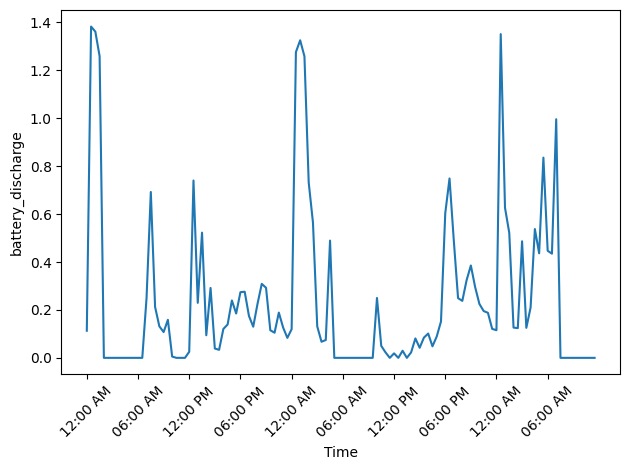

In [27]:
toplot = 'battery_discharge'
# Extract the correction_factor, replacing null values with np.nan
plot_factors = []
for entry in data:
    # Check if the reward_info and correction_factor exist; otherwise, use np.nan.
    if entry.get('reward_info') is not None and entry['reward_info'].get(toplot) is not None:
        plot_factors.append(entry['reward_info'][toplot])
    else:
        plot_factors.append(np.nan)

num_points = len(plot_factors)

time_indices = np.arange(slice_start, slice_end)

time_labels = []
for i in time_indices:
    total_minutes = (i * 30) % 1440  # minutes in a day (24*60 = 1440)
    hour = total_minutes // 60
    minute = total_minutes % 60
    # Convert 24h clock to 12h format with AM/PM
    if hour == 0:
        hour_12 = 12
        meridiem = "AM"
    elif hour < 12:
        hour_12 = hour
        meridiem = "AM"
    elif hour == 12:
        hour_12 = hour
        meridiem = "PM"
    else:
        hour_12 = hour - 12
        meridiem = "PM"
    time_labels.append(f"{hour_12:02d}:{minute:02d} {meridiem}")

# Plot your factors with custom x-axis labels.
plt.plot(time_indices, plot_factors)
plt.xlabel("Time")
plt.ylabel(toplot)

# Show labels at a reasonable interval (e.g., every 12 steps = 6 hours)
step = 12
plt.xticks(time_indices[::step], np.array(time_labels)[::step], rotation=45)
plt.tight_layout()
plt.show()